# Import libraries

In [1]:
# For autoreload of python modules imported
!pip install Ipython --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.3/817.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.7.1
    Uninstalling traitlets-5.7.1:
      Successfully uninstalled traitlets-5.7.1
  Attempting uninstall: Ipython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      Successfully uninstalled ipython-7.34.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 8.25.0 which is incompatible.


In [ ]:
%load_ext autoreload
#%reload_ext autoreload
%autoreload 2

import os

import pandas as pd # for data manipulation and preprocessing
import numpy as np  # for numerical calculations on vectors
import matplotlib.pyplot as plt # for visualization
import statsmodels.api as sm # for GLM
from scipy import stats
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_poisson_deviance, mean_squared_error
from sklearn.model_selection import train_test_split


#import pylatex

In [ ]:
# to avoid pandas warnings on chaining
pd.set_option('mode.chained_assignment',None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# the library developed for the analysis
import sys
sys.path.append('/content/drive/My Drive/D&O/')

from library.ExploratoryDataAnalysis import ExploratoryDataAnalysis
from library.DatasetForModeling import DatasetForModeling
from library.Results import Result
from library.GLMWrapper import GLMWrapper
from library.utils import run_kruskal_test, forward_feature_selection
from library.utils import vuong_test

# Import the data

In [ ]:
project_path = '/content/drive/MyDrive/D&O/final notebooks'

In [ ]:
data_US = pd.read_excel(os.path.join(project_path, 'frequency.xlsx'), index_col=0)
data_US.head()

,CIQ,Year,Adr,Age After Claim,Market Cap,Activist Investor,Total Claims,Sector,Debt To Equity
206,IQ19609,2011,0,11,13063.683365,22.54,0,Media and Entertainment,775.871561
207,IQ19609,2012,0,12,16440.298701,18.85,0,Media and Entertainment,775.871561
208,IQ19609,2013,0,13,17342.355917,19.87,0,Media and Entertainment,775.871561
209,IQ19609,2014,0,14,27284.912293,12.87,0,Media and Entertainment,775.871561
210,IQ19609,2015,0,15,32688.271665,11.89,2,Media and Entertainment,775.871561


In [ ]:
# number of companies in the frequency dataset
data_US['CIQ'].nunique()

16459

In [ ]:
(data_US['Total Claims']).sum()

9084

In [ ]:
data_US.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102464 entries, 206 to 8073
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CIQ                102464 non-null  object 
 1   Year               102464 non-null  int64  
 2   Adr                102464 non-null  int64  
 3   Age After Claim    102464 non-null  int64  
 4   Market Cap         102464 non-null  float64
 5   Activist Investor  102464 non-null  float64
 6   Total Claims       102464 non-null  int64  
 7   Sector             102464 non-null  object 
 8   Debt To Equity     102464 non-null  float64
dtypes: float64(3), int64(4), object(2)
memory usage: 7.8+ MB


## Preprocess data

In [ ]:
target = 'Total Claims'

binary = []
categorical = ['Sector', 'Year', 'Age After Claim']
numerical = ['Market Cap','Activist Investor', 'Debt To Equity']

dataset_US = DatasetForModeling(data_US, target, binary, categorical, numerical)

dataset_US_random_split = DatasetForModeling(data_US, target, binary, categorical, numerical)
dataset_US.data.shape

(102464, 7)

In [ ]:
# cap all numerical covariables by the IQR - means that every value will be contained in the range
dataset_US.fit_capByIQR(['Market Cap'])
dataset_US.apply_capByIQR()

dataset_US_random_split.fit_capByIQR(['Market Cap'])
dataset_US_random_split.apply_capByIQR()

Number of rows capped for Market Cap  = 14444
Number of rows capped for Market Cap  = 14444


In [ ]:
dataset_US.data.describe()

,Year,Age After Claim,Market Cap,Activist Investor,Debt To Equity,Total Claims
count,102464.000000,102464.000000,102464.000000,102464.000000,102464.000000,102464.000000
mean,2011.872336,12.040726,1981.620390,2.690953,90.808437,0.088656
std,4.602066,10.787868,2534.812006,6.985223,125.244307,0.376244
min,2005.000000,0.000000,50.004490,0.000000,0.000200,0.000000
25%,2008.000000,3.000000,156.603741,0.000000,36.930525,0.000000
50%,2012.000000,10.000000,615.354597,0.073000,68.337267,0.000000
75%,2016.000000,18.000000,2951.328809,1.702500,68.931625,0.000000
max,2020.000000,57.000000,7143.416411,100.000000,775.871561,13.000000


In [ ]:
year_split = 2016
train_index = dataset_US.data['Year'] <= year_split
test_index = ~train_index
dataset_US.prepare(train_index = train_index, test_index = test_index)

First Sector Automobiles and Components
Dataset ready
Xtrain (80813, 30)
Xtest (21651, 30)
ytrain (80813,)
ytest (21651,)


In [ ]:
# Set a random seed for reproducibility
np.random.seed(42)

# Generate a random boolean mask for the split
mask = np.random.rand(len(dataset_US_random_split.data)) < 0.8

# Create the training and test series
train_index = mask
test_index = ~mask
dataset_US_random_split.prepare(train_index = train_index, test_index = test_index)

First Sector Automobiles and Components
Dataset ready
Xtrain (82064, 30)
Xtest (20400, 30)
ytrain (82064,)
ytest (20400,)


In [ ]:
dataset_US.Xtrain.head()

,Year,Age After Claim,Market Cap,Activist Investor,Debt To Equity,const,Sector_Banks,Sector_Capital Goods,Sector_Commercial and Professional Services,Sector_Consumer Discretionary Distribution and Retail,...,Sector_Materials,Sector_Media and Entertainment,"Sector_Pharmaceuticals, Biotechnology and Life Sciences",Sector_Real Estate Management and Development,Sector_Semiconductors and Semiconductor Equipment,Sector_Software and Services,Sector_Technology Hardware and Equipment,Sector_Telecommunication Services,Sector_Transportation,Sector_Utilities
206,2011,11,2.054058,2.907286,5.612786,1,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
207,2012,12,2.054058,2.368593,5.612786,1,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
208,2013,13,2.054058,2.517500,5.612786,1,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
209,2014,14,2.054058,1.495591,5.612786,1,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
210,2015,15,2.054058,1.352523,5.612786,1,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


In [ ]:
df = pd.DataFrame()
df['Train Year(%)'] = dataset_US.ytrain.value_counts()/len(dataset_US.ytrain)*100
df['Test Year(%)'] = dataset_US.ytest.value_counts()/len(dataset_US.ytest)*100
df['Train Random(%)'] = dataset_US_random_split.ytrain.value_counts()/len(dataset_US_random_split.ytrain)*100
df['Test Random(%)'] = dataset_US_random_split.ytest.value_counts()/len(dataset_US_random_split.ytest)*100
df = df.reindex(range(0,14)).fillna(0)
print(df.style.format(precision=3).to_latex())

\begin{tabular}{lrrrr}
 & Train Year(%) & Test Year(%) & Train Random(%) & Test Random(%) \\
Total Claims &  &  &  &  \\
0 & 93.954 & 90.513 & 93.178 & 93.422 \\
1 & 4.741 & 7.085 & 5.276 & 5.074 \\
2 & 0.976 & 1.792 & 1.158 & 1.113 \\
3 & 0.238 & 0.513 & 0.294 & 0.304 \\
4 & 0.063 & 0.083 & 0.066 & 0.074 \\
5 & 0.011 & 0.009 & 0.013 & 0.000 \\
6 & 0.005 & 0.005 & 0.002 & 0.015 \\
7 & 0.002 & 0.000 & 0.002 & 0.000 \\
8 & 0.002 & 0.000 & 0.002 & 0.000 \\
9 & 0.004 & 0.000 & 0.004 & 0.000 \\
10 & 0.000 & 0.000 & 0.000 & 0.000 \\
11 & 0.000 & 0.000 & 0.000 & 0.000 \\
12 & 0.001 & 0.000 & 0.001 & 0.000 \\
13 & 0.002 & 0.000 & 0.002 & 0.000 \\
\end{tabular}



In [ ]:
print(dataset_US.ytrain.mean()*100)
print(dataset_US.ytest.mean()*100)
print(dataset_US_random_split.ytrain.mean()*100)
print(dataset_US_random_split.ytest.mean()*100)

7.861358939774542
12.613736086093022
8.9332715929031
8.593137254901961


## Fit Discrete Distributions to Claim counts

In [ ]:
distribution_results = dict()

In [ ]:
# Descriptive statistics of Total Claims
dataset_US.ytrain.describe()

count    80813.000000
mean         0.078614
std          0.357903
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         13.000000
Name: Total Claims, dtype: float64

In [ ]:
dataset_US.ytrain.value_counts()

Total Claims
0     75927
1      3831
2       789
3       192
4        51
5         9
6         4
9         3
13        2
7         2
8         2
12        1
Name: count, dtype: int64

In [ ]:
ytrain = dataset_US.data[target]
ytest = dataset_US.data[target]

histograms_distribution = dict()

In [ ]:
mu = ytrain.mean()
sigma = ytrain.std()
lambda_poisson = mu
print(f"mu={mu:.3e}")
print(f"sigma={sigma:.3e}")

mu=8.866e-02
sigma=3.762e-01


### Regular Poisson

In [ ]:
bar_plot_style  = {'color':'black', 'fill':False, 'hatch':'/' } # 'width':1.0
bar_plot_style_hist = {k:v for k,v in bar_plot_style.items() if k != 'width'}

Log-likelihood = -32899.842
Likelihood = 87859.367


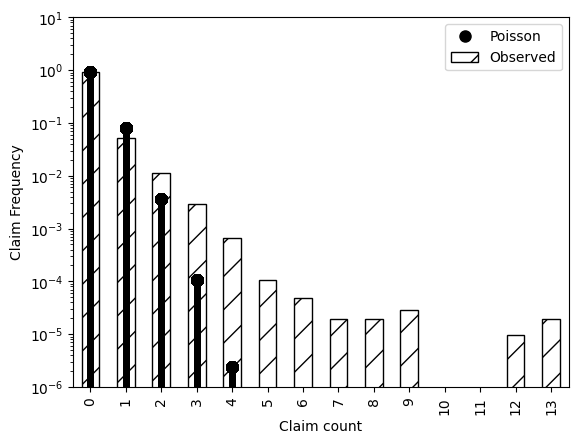

In [ ]:
log_likelihood = np.sum(stats.poisson.logpmf(ytest, mu))
likelihood = np.sum(stats.poisson.pmf(ytest, mu))
print(f"Log-likelihood = {log_likelihood:.3f}")
print(f"Likelihood = {likelihood:.3f}")

distribution_results['poisson'] = {'likelihood':likelihood, 'num_params':1, 'pmf':stats.poisson.pmf(ytest, mu)}

plt.plot(ytest, stats.poisson.pmf(ytest, mu), 'ko', ms=8, label='Poisson')
plt.vlines(ytest, 0, stats.poisson.pmf(ytest, mu), colors='k', lw=5, alpha=0.5)
(ytest.value_counts()/len(ytest)).reindex(range(0,14), fill_value=0).plot.bar(label='Observed', **bar_plot_style)
plt.ylim([1e-6,1e1])
plt.yscale('log')
plt.xlabel('Claim count')
plt.ylabel('Claim Frequency')
plt.legend()
plt.show();

### Negative Binomial (Overdispersed Poisson)

Log-likelihood = -30335.899
Likelihood = 89349.358
[0.15537967 0.63671008]


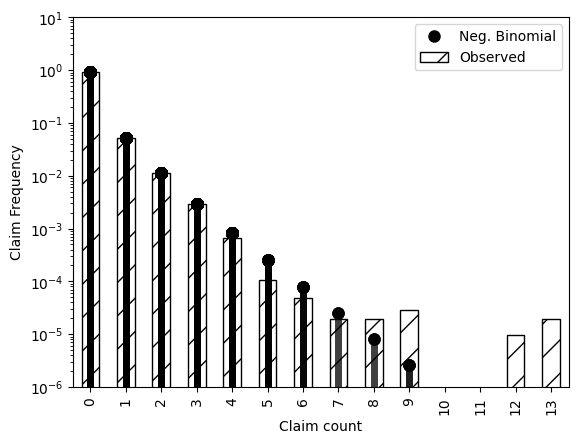

In [ ]:
# Negative Binomial
from scipy.optimize import minimize
def log_likelihood(params, x):
    n, p = params
    return -np.sum(stats.nbinom.logpmf(x, n, p))

# Estimate the parameters using maximum likelihood estimation
n0 = mu**2/(sigma**2 - mu)
p0 = mu/(sigma**2)
params0 = [n0, p0]  # initial parameter values
results = minimize(log_likelihood, params0, args=(ytrain,))
params = results.x
loglikelihood = np.sum(stats.nbinom.logpmf(ytest,*params))
likelihood = np.sum(stats.nbinom.pmf(ytest,*params))
print(f"Log-likelihood = {loglikelihood:.3f}")
print(f"Likelihood = {likelihood:.3f}")
print(params)

distribution_results['negative binomial'] = {'likelihood':likelihood, 'num_params':len(params), 'pmf':stats.nbinom.pmf(ytest,*params)}

x = ytest.sort_values()
plt.plot(x, stats.nbinom.pmf(x, *params), 'ko', ms=8, label='Neg. Binomial')
plt.vlines(x, 0, stats.nbinom.pmf(x, *params), colors='k', lw=5, alpha=0.5)
(x.value_counts()/len(ytest)).reindex(range(0,14), fill_value=0).plot.bar(label='Observed', **bar_plot_style)

plt.ylim([1e-6,1e1])
plt.yscale('log')
plt.xlabel('Claim count')
plt.ylabel('Claim Frequency')
plt.legend()
plt.show()

### Hurdle Poisson

In [ ]:
#https://en.wikipedia.org/wiki/Hurdle_model
# First model the Bernoulli
p = sum(ytrain>0)/len(ytrain)
print(p)
x_zero = [0]

0.0677311055590256


In [ ]:
# Second, model the Poisson part
positive_data_train = ytrain[ytrain>0]
mu_positive = positive_data_train.mean()

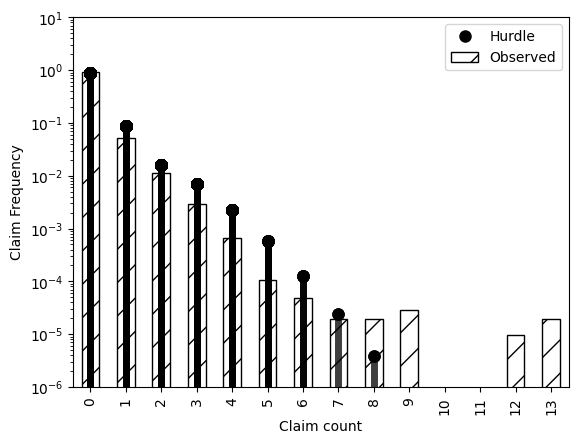

In [ ]:
from scipy.stats import bernoulli
# Third, put together the bernoulli and poisson

hurdle_pmf = (1-p)*bernoulli.pmf(ytest, p) + p*stats.poisson.pmf(ytest, mu_positive) # for 0s, only depends on Bernoulli
#hurdle_pmf[1:] = stats.poisson.pmf(x[1:], mu_positive)*p # for greater than 0, is joint distribution (Ber, Poisson)

likelihood = sum(hurdle_pmf)

distribution_results['hurdle'] = {'likelihood':likelihood, 'num_params':2,'pmf':hurdle_pmf}

plt.plot(ytest, hurdle_pmf, 'ko', ms=8, label='Hurdle')
plt.vlines(ytest, 0, hurdle_pmf, colors='k', lw=5, alpha=0.5)
(ytest.value_counts()/len(ytest)).reindex(range(0,14), fill_value=0).plot.bar(label='Observed', **bar_plot_style)
plt.ylim([1e-6,1e1])
plt.yscale('log')
plt.xlabel('Claim count')
plt.ylabel('Claim Frequency')
plt.legend()
plt.show()

In [ ]:
for dist in distribution_results:
  distribution_results[dist]['likelihood'] = np.round(distribution_results[dist]['likelihood'], 3)

print([value for value in distribution_results])
[value['likelihood'] for value in distribution_results.values()]

['poisson', 'negative binomial', 'hurdle']


[87859.367, 89349.358, 85257.826]

### Compare distributions using Vuong test

In [ ]:
voung_test_results = dict()

In [ ]:
model1 = 'negative binomial'
model2 = 'poisson'
z, p, preferred = vuong_test(distribution_results, model1, model2, len(ytest))
voung_test_results[model1 + " vs " + model2] = {"preferred": preferred, "pvalue": p}

0.1563826555335942
=== Vuong Test Results ===
    -> model 1 preferred over model 2
    -> Z: 20.254825566014734
    -> p: 0.0


In [ ]:
model1 = 'negative binomial'
model2 = 'hurdle'
z, p, preferred = vuong_test(distribution_results, model1, model2, len(ytest))
voung_test_results[model1 + " vs " + model2] = {"preferred": preferred, "pvalue": p}

0.020731415326314596
=== Vuong Test Results ===
    -> model 1 preferred over model 2
    -> Z: 27.64376279996947
    -> p: 0.0


In [ ]:
model1 = 'hurdle'
model2 = 'poisson'
z, p, preferred = vuong_test(distribution_results, model1, model2, len(ytest))
voung_test_results[model1 + " vs " + model2] = {"preferred": preferred, "pvalue": p}

0.1751429591865691
=== Vuong Test Results ===
    -> model 1 preferred over model 2
    -> Z: 9.628556441901718
    -> p: 0.0


## Exploratory Data Analysis

### Descriptive statistics

In [ ]:
# Descriptive statistics for report
pd.set_option("display.precision", 3)
descriptive_statistics = data_US.describe().drop(['Adr','Year', 'Age After Claim'], axis=1)
#descriptive_statistics['Year'] = descriptive_statistics['Year'].astype(int)
descriptive_statistics = descriptive_statistics.loc[['mean', 'std'],:]
descriptive_statistics.loc['median', :] = data_US[descriptive_statistics.columns].median()
# make it in billions
currency_columns = ['Market Cap']
descriptive_statistics[currency_columns] = descriptive_statistics[currency_columns]/1e3
#descriptive_statistics = descriptive_statistics.rename(columns = {col: col + " (Billions USD)" for col in currency_columns})
descriptive_statistics = descriptive_statistics.round(3)
descriptive_statistics
print(descriptive_statistics.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & Market Cap & Activist Investor & Total Claims & Debt To Equity \\
\midrule
mean & 7.384000 & 2.691000 & 0.089000 & 90.808000 \\
std & 38.281000 & 6.985000 & 0.376000 & 125.244000 \\
median & 0.615000 & 0.073000 & 0.000000 & 68.337000 \\
\bottomrule
\end{tabular}



In [ ]:
print(data_US['Total Claims'].value_counts().sort_index().to_latex())
print(data_US['Total Claims'].value_counts().sort_index())

\begin{tabular}{lr}
\toprule
 & count \\
Total Claims &  \\
\midrule
0 & 95524 \\
1 & 5365 \\
2 & 1177 \\
3 & 303 \\
4 & 69 \\
5 & 11 \\
6 & 5 \\
7 & 2 \\
8 & 2 \\
9 & 3 \\
12 & 1 \\
13 & 2 \\
\bottomrule
\end{tabular}

Total Claims
0     95524
1      5365
2      1177
3       303
4        69
5        11
6         5
7         2
8         2
9         3
12        1
13        2
Name: count, dtype: int64


In [ ]:
data_US.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102464 entries, 206 to 8073
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CIQ                102464 non-null  object 
 1   Year               102464 non-null  int64  
 2   Adr                102464 non-null  int64  
 3   Age After Claim    102464 non-null  int64  
 4   Market Cap         102464 non-null  float64
 5   Activist Investor  102464 non-null  float64
 6   Total Claims       102464 non-null  int64  
 7   Sector             102464 non-null  object 
 8   Debt To Equity     102464 non-null  float64
dtypes: float64(3), int64(4), object(2)
memory usage: 7.8+ MB


In [ ]:
# Number of sectors in the data
len(data_US['Sector'].unique())

25

In [ ]:
eda_US = ExploratoryDataAnalysis(data_US, 'frequency')

## Histogram for each covariable and output

(0.0, 7.498087006963341)

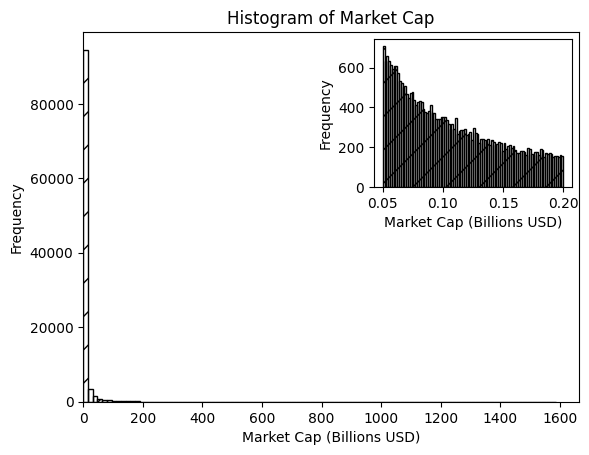

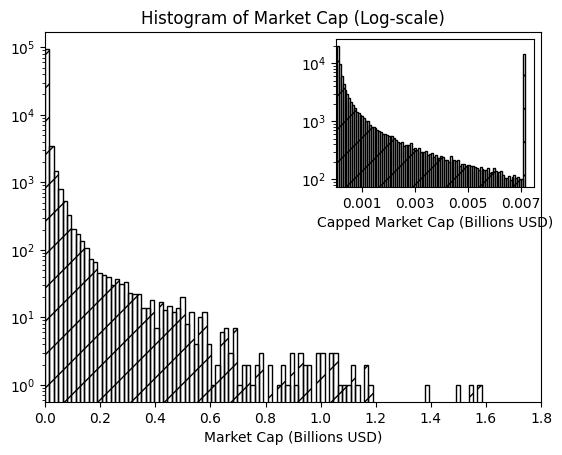

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def histogram_market_cap():
  eda_US.plotHistogram("Market Cap", bins=np.logspace(np.log10(1e0),np.log10(1e9), 20), density=False)

plt.figure()
#plt.subplot(1, 2, 1)
(data_US['Market Cap']/1e3).plot.hist(bins=100, **bar_plot_style)
plt.title("Histogram of Market Cap")
# # Get current xticks
# xticks = plt.xticks()[0]
# # Divide xticks by a constant (e.g., 2)
# new_xticks = xticks / 1e3
# # Set the new xticks
# plt.xticks(xticks, new_xticks)
plt.xlabel("Market Cap (Billions USD)")
plt.xlim(left=0)
ax = plt.gca()

# Create an inset Axes
# The parameters are: [left, bottom, width, height] in percentage of the figure size
inset_ax = inset_axes(ax, width="40%", height="40%", loc='upper right')
                      # bbox_to_anchor=(0.5, 0.1, 1, 1),
                      # bbox_transform=ax.transAxes)

# Example data for inset plot
(data_US['Market Cap']/1e3)[data_US['Market Cap']<200].plot.hist(ax = inset_ax, bins=100, **bar_plot_style)
plt.xlabel("Market Cap (Billions USD)")

#plt.subplot(1, 2, 2)
plt.figure()
(data_US['Market Cap']/1e3).plot.hist(bins=100, **bar_plot_style)
ax = plt.gca()
ax.set_ylabel("")
ax.set_yscale('log')
ax.set_title("Histogram of Market Cap (Log-scale)")
# Get current xticks
xticks = plt.xticks()[0]
# Divide xticks by a constant (e.g., 2)
new_xticks = xticks / 1e3
# Set the new xticks
plt.xticks(xticks, new_xticks)
plt.xlabel("Market Cap (Billions USD)")
plt.xlim(left=0)

ax = plt.gca()

# Create an inset Axes
# The parameters are: [left, bottom, width, height] in percentage of the figure size
inset_ax = inset_axes(ax, width="40%", height="40%", loc='upper right')
                      # bbox_to_anchor=(0.5, 0.1, 1, 1),
                      # bbox_transform=ax.transAxes)

# Example data for inset plot
(dataset_US.data['Market Cap']/1e3).plot.hist(ax = inset_ax, bins=100, **bar_plot_style)
ax = plt.gca()
ax.set_ylabel("")
ax.set_yscale('log')
# Get current xticks
xticks = plt.xticks()[0]
# Divide xticks by a constant (e.g., 2)
new_xticks = xticks / 1e3
# Set the new xticks
plt.xticks(xticks[::2], new_xticks[::2])
plt.xlabel("Capped Market Cap (Billions USD)")
plt.xlim(left=0)


(0.0, 8.0)

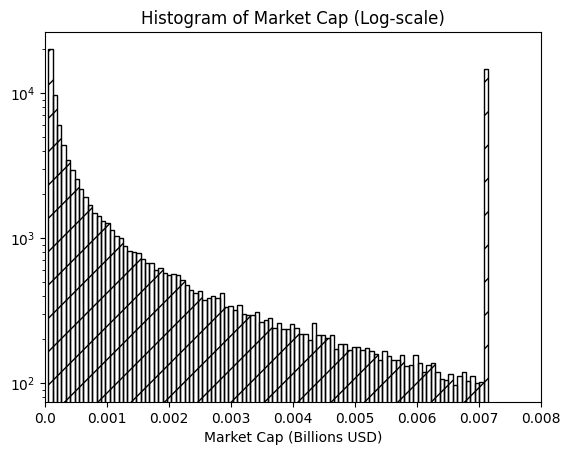

In [ ]:
#plt.subplot(1, 2, 2)
plt.figure()
(dataset_US.data['Market Cap']/1e3).plot.hist(bins=100, **bar_plot_style)
ax = plt.gca()
ax.set_ylabel("")
ax.set_yscale('log')
ax.set_title("Histogram of Market Cap (Log-scale)")
# Get current xticks
xticks = plt.xticks()[0]
# Divide xticks by a constant (e.g., 2)
new_xticks = xticks / 1e3
# Set the new xticks
plt.xticks(xticks, new_xticks)
plt.xlabel("Market Cap (Billions USD)")
plt.xlim(left=0)

In [ ]:
data_US['Market Cap'].describe()

count    1.025e+05
mean     7.384e+03
std      3.828e+04
min      5.000e+01
25%      1.566e+02
50%      6.154e+02
75%      2.951e+03
max      1.585e+06
Name: Market Cap, dtype: float64

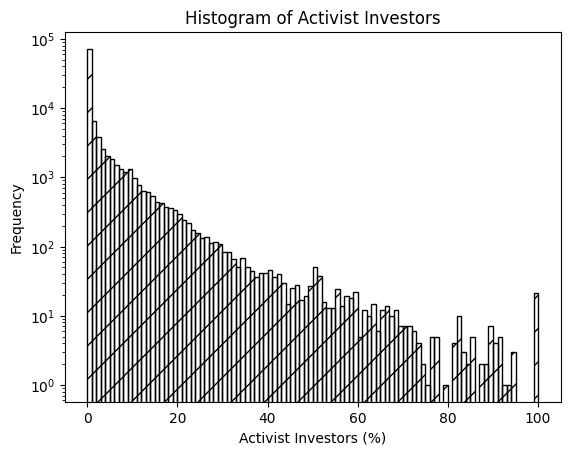

In [ ]:
bar_plot_style  = {'color':'black', 'fill':False, 'hatch':'/' } #  'width':1.0
bar_plot_style_hist = {k:v for k,v in bar_plot_style.items() if k != 'width'}

# Create a histogram
data_US['Activist Investor'].plot.hist(bins=100, **bar_plot_style)
#plt.hist(data_US['Activist Investor'], bins=range(int(data_US['Activist Investor'].min()), int(data_US['Activist Investor'].max()) + 2, 20), align='left', rwidth=0.8, **bar_plot_style_hist)

# Setting the labels and titles
plt.xlabel('Activist Investors (%)')
plt.ylabel('Frequency')
plt.title('Histogram of Activist Investors')
plt.yscale('log')

# Show the plot
plt.show()

Directory already exists
File with same name already exists!


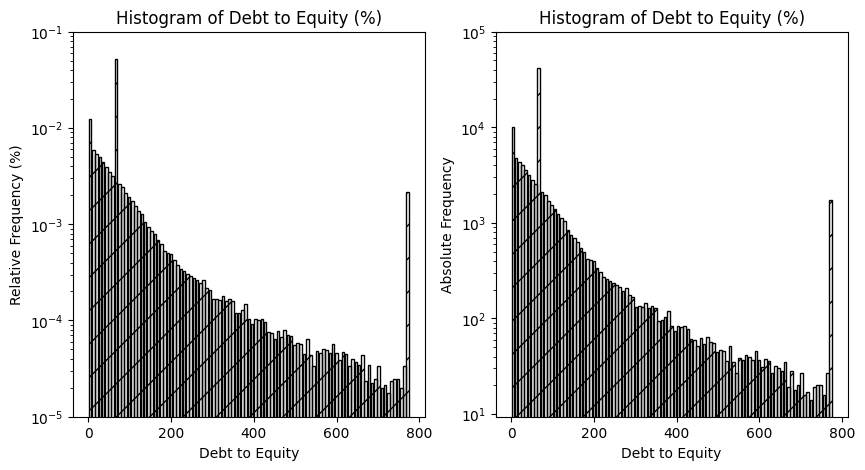

In [ ]:
from matplotlib.ticker import ScalarFormatter, LogFormatter, FuncFormatter

def histogram_debt_to_equity(density=True):
  eda_US.plotHistogram("Debt To Equity", bins = 100, density=density)
  ax = plt.gca()
  ax.set_xlabel("Debt to Equity")
  ax.set_ylabel("Relative Frequency (%)")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
histogram_debt_to_equity(True)
ax = plt.gca()
#ax.set_yticks(np.logspace(-5, -1, 5))
current_ticks = np.logspace(-5, -1, 5)
# Set new y-ticks multiplied by 100
ax.set_yticks(current_ticks)
# Set the tick labels with the new values multiplied by 100
ax.set_yticklabels([f"{tick * 100:.0e}" for tick in current_ticks])
ax.set_title("Histogram of Debt to Equity (%)")
# # Set the formatter for the y-axis to use scientific notation
# formatter = ScalarFormatter(useMathText=True)  # useMathText will render the '10' as an exponent
# formatter.set_scientific(True)
# formatter.set_powerlimits((-1,1))  # This will force scientific notation for all numbers outside 10^-1 to 10^1
# ax.yaxis.set_major_formatter(formatter)
# formatter = LogFormatter(base=10, labelOnlyBase=False)
# ax.yaxis.set_major_formatter(formatter)
# Define a custom formatter function
def log_formatter(x, pos):
    return f'$10^{{{int(np.log10(x))}}}$'

# Apply the formatter function to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(log_formatter))

plt.subplot(1,2,2)
histogram_debt_to_equity(False)
plt.ylabel("Absolute Frequency")
ax = plt.gca()
ax.set_yticks(np.logspace(1, 5, 5))
ax.set_title("Histogram of Debt to Equity (%)")

eda_US.complete()

Text(0, 0.5, 'Absolute Frequency($10^{2}$)')

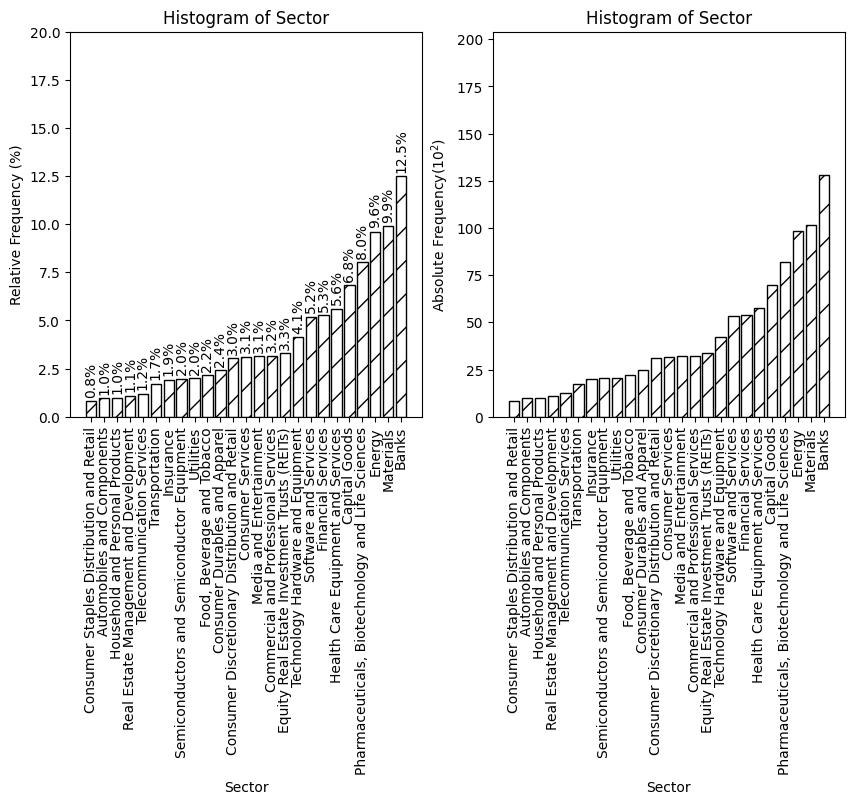

In [ ]:
columnToGroup = "Sector"
agg_data = data_US.groupby(by=columnToGroup).size()
agg_data = agg_data.sort_values()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
bars = plt.bar(agg_data.index, agg_data.values/len(data_US)*100, **bar_plot_style)
plt.xlabel(columnToGroup)
plt.xticks(rotation=90)
plt.ylim([0,20])
ax = plt.gca()

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{np.round(height, 1)}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                rotation = 90,
                textcoords="offset points",
                ha='center', va='bottom')


ax.set_title("Histogram of Sector")
#ax.set_ylim([0,len(data_US)])
# ax = plt.gca()
# # Get current xticks
# yticks = plt.yticks()[0]
# # Make it as a percentage of total
# new_yticks = np.round(yticks / len(data_US)*100, 0)
# Set the new xticks
# plt.yticks(yticks, new_yticks)
plt.ylabel("Relative Frequency (%)")

plt.subplot(1,2,2)
bars = plt.bar(agg_data.index, agg_data.values/100, **bar_plot_style)
plt.xlabel(columnToGroup)
plt.xticks(rotation=90)
plt.ylim([0,int(0.2*len(data_US)/100)])
plt.title("Histogram of Sector")
plt.ylabel("Absolute Frequency($10^{2}$)")

Text(0.5, 0, 'Industry Sector')

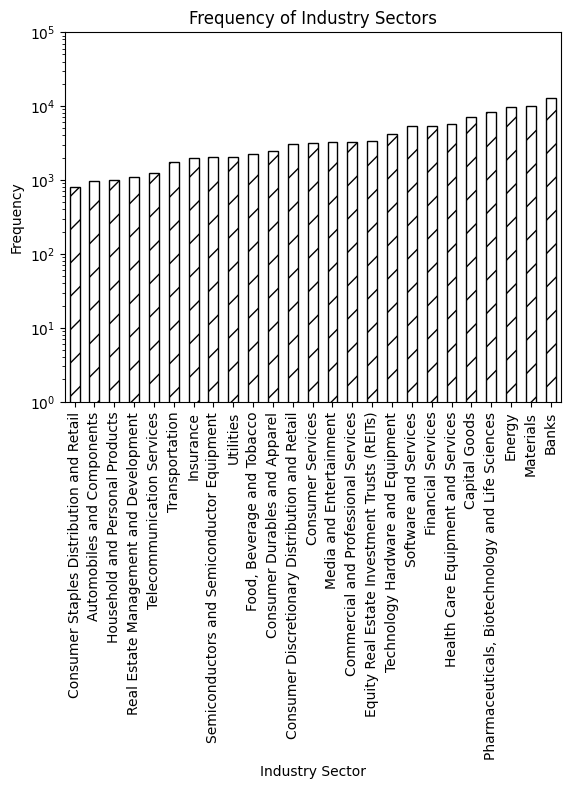

In [ ]:

# count of policies per sector
eda_US.barplotByGroup('Sector', ylim=[1, 1e5])
plt.title("Frequency of Industry Sectors")
plt.xlabel("Industry Sector")

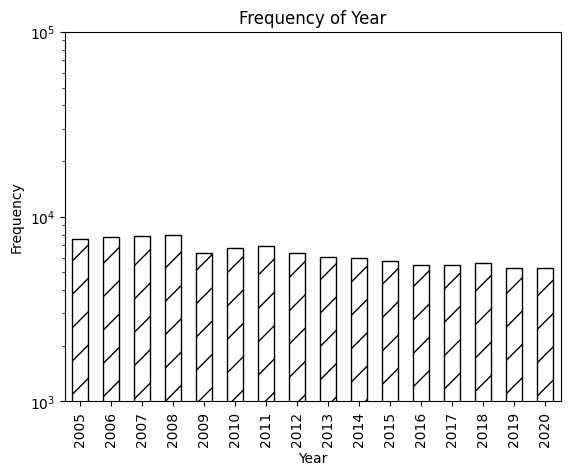

In [ ]:
#count policies by year
eda_US.barplotByGroup('Year', sort_index = True, ylim=[1e3, 1e5])

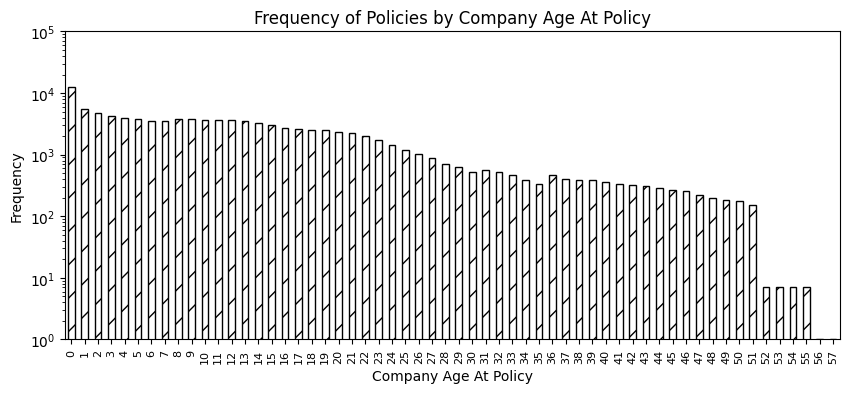

In [ ]:
#count policies by ipo year
eda_US.barplotByGroup('Age After Claim', sort_index = True, ylim=[1, 1e5])
plt.xticks(fontsize=8)
plt.title("Frequency of Policies by Company Age At Policy")
plt.xlabel("Company Age At Policy")
#plt.xlim([2005, 2020])
fig = plt.gcf()
# change the size of the figure
fig.set_size_inches(10, 4)


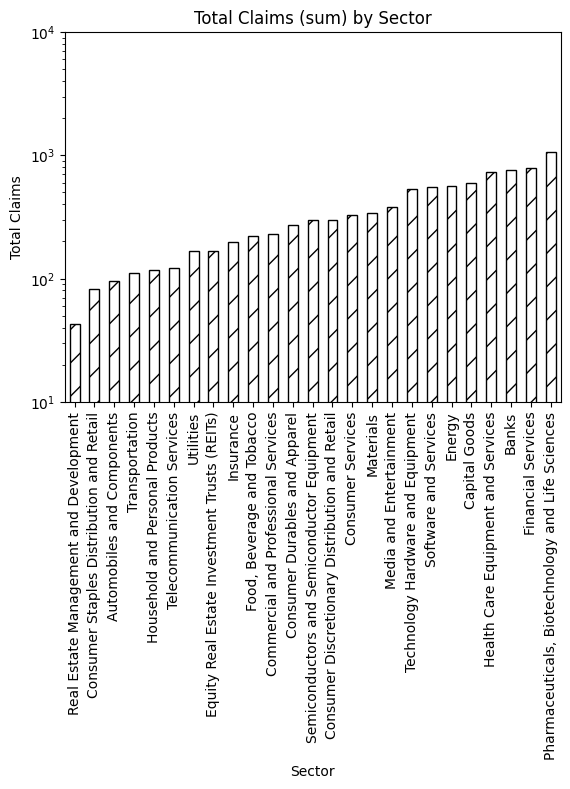

In [ ]:
eda_US.barplotByGroupSum('Total Claims', 'Sector', ylim=[1e1, 1e4])

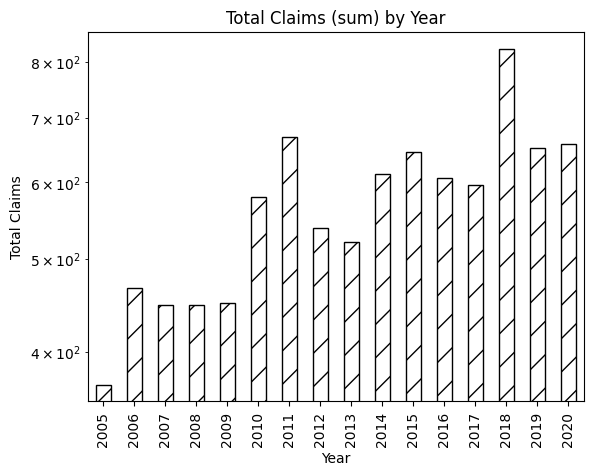

In [ ]:
eda_US.barplotByGroupSum('Total Claims', 'Year', sort_index=True)

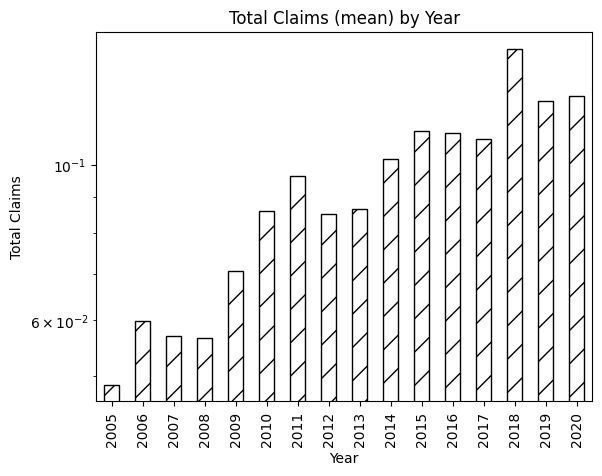

In [ ]:
eda_US.barplotByGroupMean('Total Claims', 'Year', sort_index=True)

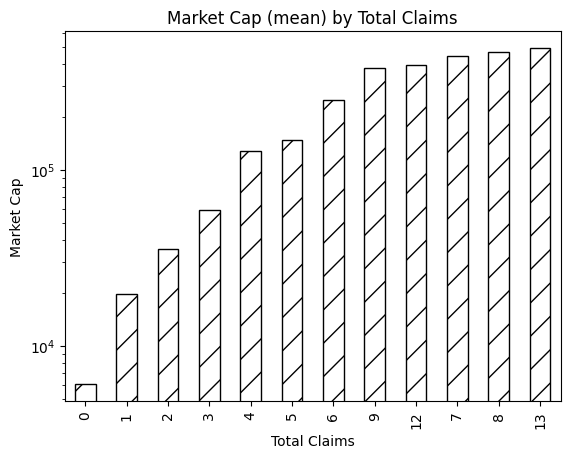

In [ ]:
eda_US.barplotByGroupMean('Market Cap', 'Total Claims')

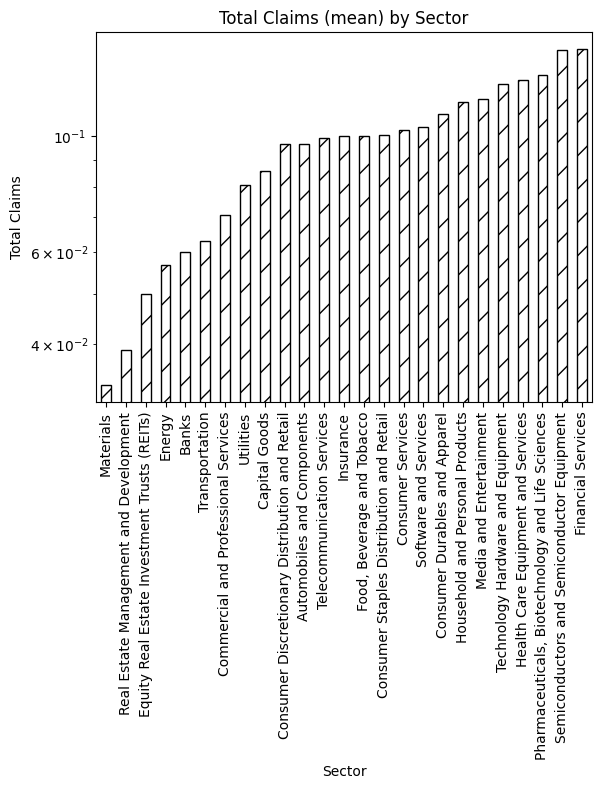

In [ ]:
eda_US.barplotByGroupMean('Total Claims', 'Sector')

## Correlation analysis

In [ ]:
# need this to calculate the pvalues for the correlations
from scipy.stats import pearsonr, spearmanr
from itertools import combinations

pairs = list(combinations(dataset_US.data[numerical + [target]].columns, 2))

pearson = dict()
for (col1, col2) in pairs:
  print(col1, col2)
  print(pearsonr(dataset_US.data[col1], dataset_US.data[col2]))
  print(spearmanr(dataset_US.data[col1], dataset_US.data[col2]))

Market Cap Activist Investor
PearsonRResult(statistic=-0.021278954326403907, pvalue=9.619686560473673e-12)
SignificanceResult(statistic=0.36720524385573833, pvalue=0.0)
Market Cap Debt To Equity
PearsonRResult(statistic=0.06756048702954352, pvalue=6.001295906891455e-104)
SignificanceResult(statistic=0.067535523493621, pvalue=7.141412566092914e-104)
Market Cap Total Claims
PearsonRResult(statistic=0.15064967253382905, pvalue=0.0)
SignificanceResult(statistic=0.14916189773128, pvalue=0.0)
Activist Investor Debt To Equity
PearsonRResult(statistic=0.030843202120067397, pvalue=5.335984137123836e-23)
SignificanceResult(statistic=0.021126325290301968, pvalue=1.3496865373875407e-11)
Activist Investor Total Claims
PearsonRResult(statistic=0.034956979072438846, pvalue=4.411842789287941e-29)
SignificanceResult(statistic=0.13143797803013954, pvalue=0.0)
Debt To Equity Total Claims
PearsonRResult(statistic=0.037417982221744604, pvalue=4.439716857868075e-33)
SignificanceResult(statistic=0.0177141397

In [ ]:
print(dataset_US.data[numerical + [target]].corr(method='pearson').round(3).style.to_latex())

\begin{tabular}{lrrrr}
 & Market Cap & Activist Investor & Debt To Equity & Total Claims \\
Market Cap & 1.000000 & -0.021000 & 0.068000 & 0.151000 \\
Activist Investor & -0.021000 & 1.000000 & 0.031000 & 0.035000 \\
Debt To Equity & 0.068000 & 0.031000 & 1.000000 & 0.037000 \\
Total Claims & 0.151000 & 0.035000 & 0.037000 & 1.000000 \\
\end{tabular}



In [ ]:

print(dataset_US.data[numerical + [target]].corr(method='spearman').round(3).style.format(precision=3).to_latex())

\begin{tabular}{lrrrr}
 & Market Cap & Activist Investor & Debt To Equity & Total Claims \\
Market Cap & 1.000 & 0.367 & 0.068 & 0.149 \\
Activist Investor & 0.367 & 1.000 & 0.021 & 0.131 \\
Debt To Equity & 0.068 & 0.021 & 1.000 & 0.018 \\
Total Claims & 0.149 & 0.131 & 0.018 & 1.000 \\
\end{tabular}



In [ ]:
from scipy.stats import pointbiserialr

# One-hot encode the 'Category' column
df_encoded = pd.get_dummies(dataset_US.data, columns=['Sector'])


# Calculate point-biserial correlation for each category against numerical columns
correlations = {}

for category_column in df_encoded.columns:
    if category_column.startswith('Sector_'):
        corr, pvalue = pointbiserialr(df_encoded[category_column], dataset_US.data['Total Claims'])
        correlations[category_column] = {'corr':corr, 'pvalue':pvalue}

corr_df = pd.DataFrame(correlations).T
corr_df.sort_values(by='corr')

,corr,pvalue
Sector_Materials,-0.049,1.060e-54
Sector_Banks,-0.029,2.997e-20
Sector_Energy,-0.028,1.022e-18
Sector_Equity Real Estate Investment Trusts (REITs),-0.019,1.235e-09
Sector_Real Estate Management and Development,-0.014,9.926e-06
Sector_Transportation,-0.009,3.933e-03
Sector_Commercial and Professional Services,-0.009,5.519e-03
Sector_Utilities,-0.003,3.327e-01
Sector_Capital Goods,-0.002,5.154e-01
Sector_Automobiles and Components,0.002,4.986e-01


# GLM Overall Configuration

In [ ]:
family=sm.families.NegativeBinomial(link=sm.genmod.families.links.Log())

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [ ]:
def aic_score(y_test, y_pred, glm_results):
  # Calculate the negative log-likelihood
  ll = -np.sum(y_test * np.log(y_pred) + (1 - y_test) * np.log(1 - y_pred))

  # Calculate the number of parameters in the model
  num_params = len(glm_results.params)

  # Calculate the AIC score
  aic = 2 * num_params - 2 * ll

  return aic

## GLM year split

In [ ]:
glms_US = {}

result_train_US = Result('Total Claims')
result_train_US.addTrueData(dataset_US.ytrain)
#result_train_US.addPredictionMetric('mean poisson deviance', mean_poisson_deviance)
result_train_US.addPredictionMetric('mean squared error', mean_squared_error)
result_train_US.addPredictionMetric('mean absolute error', mean_absolute_error)
result_train_US.addPredictionMetric('mean poisson deviance', mean_poisson_deviance)

result_test_US = Result('Total Claims')
result_test_US.addTrueData(dataset_US.ytest)
#result_test_US.addPredictionMetric('mean poisson deviance', mean_poisson_deviance)
result_test_US.addPredictionMetric('mean squared error', mean_squared_error)
result_test_US.addPredictionMetric('mean absolute error', mean_absolute_error)
result_test_US.addPredictionMetric('mean poisson deviance', mean_poisson_deviance)

### GLM with no covariables (homogeneous)

In [ ]:
name='Homogeneous'
glms_US[name] = GLMWrapper(name=name, dataset = dataset_US, covariables=['const'],  family=family)
glms_US[name].fit()
glms_US[name].calculate_performance(result_train_US, result_test_US, dataset_US)
print(glms_US[name].summary())
display(result_train_US)

                 Generalized Linear Model Regression Results                  
Dep. Variable:           Total Claims   No. Observations:                80813
Model:                            GLM   Df Residuals:                    80812
Model Family:        NegativeBinomial   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -22753.
Date:                Thu, 18 Apr 2024   Deviance:                       30616.
Time:                        08:46:39   Pearson chi2:                 1.22e+05
No. Iterations:                     5   Pseudo R-squ. (CS):          2.220e-16
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.5432      0.013   -195.182      0.0

                       Homogeneous
mean squared error           0.128
mean absolute error          0.148
mean poisson deviance        0.458
# params                     1.000
AIC                      45508.871

### GLM with all covariables plus time (GLM1)

In [ ]:
name='GLM1'
glms_US[name] = GLMWrapper(name=name, dataset = dataset_US, covariables='all',  family=family)
glms_US[name].fit()
glms_US[name].calculate_performance(result_train_US, result_test_US, dataset_US)
print(glms_US[name].summary())
display(result_train_US)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

### Forward Feature Selection (GLM1-FFS)

In [ ]:
#selected_features = forward_feature_selection(dataset_US, family=family)
#print(selected_features)

#### GLM with selected features

In [ ]:
# These features come from the forward feat. sel.
# I manually  drop Sector_Consumer Services as after all it becomes non-significant
selected_features_US = ['const'] +  ['Market Cap', 'Year', 'Sector_Materials', 'Sector_Energy', 'Sector_Equity Real Estate Investment Trusts (REITs)', 'Activist Investor', 'Sector_Pharmaceuticals, Biotechnology and Life Sciences', 'Sector_Financial Services', 'Sector_Technology Hardware and Equipment', 'Sector_Health Care Equipment and Services', 'Sector_Semiconductors and Semiconductor Equipment', 'Debt To Equity', 'Sector_Utilities', 'Sector_Transportation', 'Sector_Software and Services', 'Sector_Household and Personal Products', 'Age After Claim', 'Sector_Media and Entertainment', 'Sector_Consumer Durables and Apparel', 'Sector_Consumer Services', 'Sector_Banks', 'Sector_Real Estate Management and Development']


name='GLM1-FFS'
glms_US[name] = GLMWrapper(name=name, dataset = dataset_US, covariables=selected_features_US,  family=family)
glms_US[name].fit()
glms_US[name].calculate_performance(result_train_US, result_test_US, dataset_US)
print(glms_US[name].summary())
display(result_train_US)

In [ ]:
# How many features dropped
len(glms_US['GLM1'].glm.params) - len(glms_US['GLM1-FFS'].glm.params)
set(glms_US['GLM1'].glm.params.index).difference(set(glms_US['GLM1-FFS'].glm.params.index))

### GLM with all covariables without time (GLM2)

In [ ]:
name='GLM2'
covariables = [var for var in dataset_US.Xtrain.columns if var not in ['Year', 'Age After Claim']]

glms_US[name] = GLMWrapper(name=name, dataset = dataset_US, covariables=covariables,  family=family)
glms_US[name].fit()
glms_US[name].calculate_performance(result_train_US, result_test_US, dataset_US)
print(glms_US[name].summary())
display(result_train_US)

### Forward Feature Selection (GLM2-FFS)

In [ ]:
dataset_US_noyear = DatasetForModeling(dataset_US.data, dataset_US.target, dataset_US.binary, dataset_US.categorical, dataset_US.numerical)
dataset_US_noyear.Xtrain = dataset_US.Xtrain.drop(columns=['Year','Age After Claim'])
dataset_US_noyear.Xtest = dataset_US.Xtest.drop(columns=['Year','Age After Claim'])
dataset_US_noyear.ytrain = dataset_US.ytrain
dataset_US_noyear.ytest = dataset_US.ytest


In [ ]:
#selected_features2 = forward_feature_selection(dataset_US_noyear, family=family)
#print(selected_features2)

#### GLM with selected features

In [ ]:
# These features come from the forward feat. sel.
selected_features_US2 = ['const'] +  ['Market Cap', 'Sector_Materials', 'Activist Investor', 'Sector_Pharmaceuticals, Biotechnology and Life Sciences', 'Sector_Financial Services', 'Sector_Technology Hardware and Equipment', 'Sector_Health Care Equipment and Services', 'Sector_Semiconductors and Semiconductor Equipment', 'Sector_Equity Real Estate Investment Trusts (REITs)', 'Debt To Equity', 'Sector_Energy', 'Sector_Utilities', 'Sector_Transportation', 'Sector_Software and Services', 'Sector_Household and Personal Products', 'Sector_Media and Entertainment', 'Sector_Consumer Durables and Apparel', 'Sector_Consumer Services', 'Sector_Banks', 'Sector_Real Estate Management and Development', 'Sector_Commercial and Professional Services']

name='GLM2-FFS'
glms_US[name] = GLMWrapper(name=name, dataset = dataset_US, covariables=selected_features_US2,  family=family)
glms_US[name].fit()
glms_US[name].calculate_performance(result_train_US, result_test_US, dataset_US)
print(glms_US[name].summary())
display(result_train_US)

### Separate GLM for each year (GLM3) with significant features

In [ ]:
dataset_US_year = {}
for year in dataset_US.Xtrain['Year'].unique():
  dataset_US_year[year] = DatasetForModeling(dataset_US.data[dataset_US.data['Year']==year],dataset_US.target, dataset_US.binary, dataset_US.categorical, dataset_US.numerical )

  dataset_US_year[year].Xtrain = dataset_US.Xtrain[dataset_US.Xtrain['Year'] == year].drop(columns=['Year'])
  dataset_US_year[year].Xtest = dataset_US.Xtest[dataset_US.Xtest['Year'] == year].drop(columns=['Year'])
  dataset_US_year[year].ytrain = dataset_US.ytrain[dataset_US.Xtrain['Year'] == year].drop(columns=['Year'])
  dataset_US_year[year].ytest = dataset_US.ytest[dataset_US.Xtest['Year'] == year].drop(columns=['Year'])
  print()
  print(year)
  print(dataset_US_year[year].Xtrain.shape)
  print(dataset_US_year[year].Xtest.shape)
  print(dataset_US_year[year].ytrain.shape)
  print(dataset_US_year[year].ytest.shape)

In [ ]:
selected_features_year = {}
for year in dataset_US_year:
  selected_features_year[year] = forward_feature_selection(dataset_US_year[year], family=family)
  print()
  print(year)
  print('# features selected = ',len(selected_features_year[year]))

In [ ]:
common_features = set(list(selected_features_year.values())[0]).intersection(*list(selected_features_year.values())[1:])

# print the common words
print("Common features:", common_features)

In [ ]:
from collections import OrderedDict

selected_features_year = OrderedDict(sorted(selected_features_year.items()))

selected_features_year

In [ ]:
import collections

# Step 1: Create a dictionary of word frequencies
word_freq = collections.Counter()
for year, features in selected_features_year.items():
    word_freq.update(features)

# Step 2: Sort the dictionary by frequency to get a list of the most common words
common_words = word_freq.most_common()
#common_words[0],common_words[1] = common_words[1],common_words[0]


# Step 3: Create a numpy array to hold the occurrence data for each word
num_rows = len(common_words)
num_cols = len(selected_features_year.keys())
occurrence_data = np.zeros((num_rows, num_cols))
for j, (word, freq) in enumerate(common_words):
    for i, sublist in enumerate(selected_features_year.values()):
        occurrence_data[j, i] = sublist.count(word)

# Step 4: Create a heat map with colored cells based on occurrence data
fig, ax = plt.subplots()
im = ax.imshow(occurrence_data, cmap='Greys') #'YlOrRd'

# Customize the plot
ax.set_xticks(np.arange(num_cols))
ax.set_yticks(np.arange(num_rows))
ax.set_xticklabels([year for year in selected_features_year])
ax.set_yticklabels([word for word, freq in common_words])
ax.tick_params(axis='x', rotation=90)
ax.set_title('Significant Feature Selection per Year')
#fig.colorbar(im)
'''
# Loop over data dimensions and create text annotations for each cell
for i in range(num_rows):
    for j in range(num_cols):
        text = ax.text(j, i, occurrence_data[i, j],
                       ha='center', va='center', color='black')
'''
# Show the figure

ax = plt.gca()
caption = 'Significant Features for GLMS per year.'
description = "ADD DESCRIPTION HERE"
#common_features_figure = create_pylatex_figure(ax, caption, description)


plt.show()

In [ ]:
common_features = ['Market Cap'] #, 'Activist Investor'
# refit the glms now only using the common significant features among all years
glms_year = {}
covariables = ['const'] + list(common_features)
print(covariables)
for year in dataset_US_year:
  glm = GLMWrapper(name=year, dataset = dataset_US_year[year], covariables=covariables,  family=family)
  glm.fit()
  glms_year[year] = glm

In [ ]:
from scipy import interpolate
from tqdm import tqdm

ytrain_pred = dict()
ytest_pred = dict()
ytrain_pred_year = pd.DataFrame()
ytest_pred_year = pd.DataFrame()
results_year_train = {}
results_year_test = {}
for year in glms_year:
  ytrain_pred_year[year] = glms_year[year].glm.predict(dataset_US.Xtrain[covariables])
  ytest_pred_year[year] = glms_year[year].glm.predict(dataset_US.Xtest[covariables])
  # ytest_pred = pd.concat([ytest_pred, ytest_pred_year])
  # results_year_train[year] = {'MSE': mean_squared_error(ytrain_pred_year, dataset_US_year[year].ytrain),
  #                       'MAE': mean_absolute_error(ytrain_pred_year, dataset_US_year[year].ytrain)}
  # results_year_test[year] = {'MSE': mean_squared_error(ytest_pred_year, dataset_US_year[year].ytest),
  #                       'MAE': mean_absolute_error(ytest_pred_year, dataset_US_year[year].ytest)}

x = ytrain_pred_year.columns
for idx, row in tqdm(dataset_US.Xtrain.iterrows()):

  y = ytrain_pred_year.loc[idx, :]
  f = interpolate.interp1d(x, y)
  ypred = f(row['Year'])
  ytrain_pred[idx] = ypred

for idx, row in tqdm(dataset_US.Xtest.iterrows()):

  y = ytest_pred_year.loc[idx, :]
  f = interpolate.interp1d(x, y, fill_value='extrapolate')
  ypred = f(row['Year'])
  ytest_pred[idx] = ypred


# print(ytrain_pred.shape)
# print(ytest_pred.shape)
# display(pd.DataFrame(results_year_train))
# display(pd.DataFrame(results_year_test))

In [ ]:
ytrain_pred = pd.Series(ytrain_pred)
ytest_pred = pd.Series(ytest_pred)
result_train_US.addPrediction(ytrain_pred, 'GLM3')
result_test_US.addPrediction(ytest_pred, 'GLM3' )

### Separate GLM for each year (GLM4) with all features

In [ ]:
# refit the glms now only using the common significant features among all years
covariables = [var for var in dataset_US.Xtrain if var != 'Year']
glms4 = {}
for year in dataset_US_year:
  glm = GLMWrapper(name=year, dataset = dataset_US, covariables=covariables,  family=family)
  glm.fit()
  glms4[year] = glm

In [ ]:
ytrain_pred = dict()
ytest_pred = dict()
ytrain_pred_year = pd.DataFrame()
ytest_pred_year = pd.DataFrame()
results_year_train = {}
results_year_test = {}
for year in glms4:
  ytrain_pred_year[year] = glms4[year].glm.predict(dataset_US.Xtrain[covariables])
  ytest_pred_year[year] = glms4[year].glm.predict(dataset_US.Xtest[covariables])
  # ytest_pred = pd.concat([ytest_pred, ytest_pred_year])
  # results_year_train[year] = {'MSE': mean_squared_error(ytrain_pred_year, dataset_US_year[year].ytrain),
  #                       'MAE': mean_absolute_error(ytrain_pred_year, dataset_US_year[year].ytrain)}
  # results_year_test[year] = {'MSE': mean_squared_error(ytest_pred_year, dataset_US_year[year].ytest),
  #                       'MAE': mean_absolute_error(ytest_pred_year, dataset_US_year[year].ytest)}

x = ytrain_pred_year.columns
for idx, row in tqdm(dataset_US.Xtrain.iterrows()):

  y = ytrain_pred_year.loc[idx, :]
  f = interpolate.interp1d(x, y)
  ypred = f(row['Year'])
  ytrain_pred[idx] = ypred

for idx, row in tqdm(dataset_US.Xtest.iterrows()):

  y = ytest_pred_year.loc[idx, :]
  f = interpolate.interp1d(x, y, fill_value='extrapolate')
  ypred = f(row['Year'])
  ytest_pred[idx] = ypred

In [ ]:
ytrain_pred = pd.Series(ytrain_pred)
ytest_pred = pd.Series(ytest_pred)
##IMPORTANT
print(ytest_pred.sum()*5)
result_train_US.addPrediction(ytrain_pred, 'GLM4')
result_test_US.addPrediction(ytest_pred, 'GLM4' )

### Table with summary GLM

In [ ]:
result_train_US.metrics = result_train_US.metrics.round(3)
result_test_US.metrics = result_test_US.metrics.round(3)
print("In-sample Results")
display(result_train_US)
print("Out-of-sample Results")
display(result_test_US)


In [ ]:
print(result_train_US.metrics.drop(columns=['GLM3', 'GLM4']).to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.3f}".format,
))

print(result_train_US.metrics[['GLM3', 'GLM4']].to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.3f}".format,
))


print(result_test_US.metrics.drop(columns=['GLM3', 'GLM4']).to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.3f}".format,
))

print(result_test_US.metrics[['GLM3', 'GLM4']].to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.3f}".format,
))

In [ ]:
print(result_test_US.results.mean().to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.3f}".format,
))

## GLM random split

In [ ]:
result_train_US_random_split = Result('Total Claims')
result_train_US_random_split.addTrueData(dataset_US_random_split.ytrain)
#result_train_US.addPredictionMetric('mean poisson deviance', mean_poisson_deviance)
result_train_US_random_split.addPredictionMetric('mean squared error', mean_squared_error)
result_train_US_random_split.addPredictionMetric('mean absolute error', mean_absolute_error)
result_train_US_random_split.addPredictionMetric('mean poisson deviance', mean_poisson_deviance)

result_test_US_random_split = Result('Total Claims')
result_test_US_random_split.addTrueData(dataset_US_random_split.ytest)
#result_test_US.addPredictionMetric('mean poisson deviance', mean_poisson_deviance)
result_test_US_random_split.addPredictionMetric('mean squared error', mean_squared_error)
result_test_US_random_split.addPredictionMetric('mean absolute error', mean_absolute_error)
result_test_US_random_split.addPredictionMetric('mean poisson deviance', mean_poisson_deviance)

### GLM with no covariables (homogeneous)

In [ ]:
name='Homogeneous RS'
glms_US[name] = GLMWrapper(name=name, dataset = dataset_US_random_split, covariables=['const'],  family=family)
glms_US[name].fit()
glms_US[name].calculate_performance(result_train_US_random_split, result_test_US_random_split, dataset_US_random_split)
print(glms_US[name].summary())
display(result_train_US_random_split)

### GLM with all covariables plus time (GLM1)

In [ ]:
name='GLM1 RS'
glms_US[name] = GLMWrapper(name=name, dataset = dataset_US_random_split, covariables='all',  family=family)
glms_US[name].fit()
glms_US[name].calculate_performance(result_train_US_random_split, result_test_US_random_split, dataset_US_random_split)
print(glms_US[name].summary())
display(result_train_US_random_split)

### Forward Feature Selection (GLM1-FFS)

In [ ]:
#selected_features = forward_feature_selection(dataset_US_random_split, family=family)
#print(selected_features)

#### GLM with selected features

In [ ]:
# These features come from the forward feat. sel.
# I manually  drop Sector_Consumer Services as after all it becomes non-significant
selected_features_US = ['const'] +  ['Market Cap', 'Year', 'Sector_Materials', 'Activist Investor', 'Sector_Pharmaceuticals, Biotechnology and Life Sciences', 'Sector_Equity Real Estate Investment Trusts (REITs)', 'Sector_Energy', 'Sector_Technology Hardware and Equipment', 'Sector_Health Care Equipment and Services', 'Sector_Financial Services', 'Sector_Utilities', 'Debt To Equity', 'Sector_Semiconductors and Semiconductor Equipment', 'Sector_Software and Services', 'Sector_Transportation', 'Sector_Media and Entertainment', 'Sector_Consumer Durables and Apparel', 'Sector_Household and Personal Products', 'Sector_Real Estate Management and Development', 'Age After Claim', 'Sector_Consumer Services']


#['Market Cap', 'Activist Investor', 'Sector_Semiconductors & Semiconductor Equipment', 'Sector_Technology Hardware & Equipment', 'Sector_Pharmaceuticals, Biotechnology & Life Sciences', 'Age After Claim', 'Sector_Materials', 'Sector_Diversified Financials', 'Sector_Real Estate', 'Sector_Banks', 'Sector_Commercial  & Professional Services', 'Sector_Energy', 'Market Cap Trend', 'Year', 'Sector_Food, Beverage & Tobacco', 'Sector_Transportation', 'Sector_Telecommunication Services', 'Sector_Capital Goods'] # 'Sector_Consumer Services',


name='GLM1-FFS RS'
glms_US[name] = GLMWrapper(name=name, dataset = dataset_US_random_split, covariables=selected_features_US,  family=family)
glms_US[name].fit()
glms_US[name].calculate_performance(result_train_US_random_split, result_test_US_random_split, dataset_US_random_split)
print(glms_US[name].summary())
display(result_train_US_random_split)

In [ ]:
# How many features dropped
len(glms_US['GLM1 RS'].glm.params) - len(glms_US['GLM1-FFS RS'].glm.params)
set(glms_US['GLM1 RS'].glm.params.index).difference(set(glms_US['GLM1-FFS RS'].glm.params.index))

### GLM with all covariables without time (GLM2)

In [ ]:
name='GLM2 RS'
covariables = [var for var in dataset_US_random_split.Xtrain.columns if var not in ['Year', 'Age After Claim']]

glms_US[name] = GLMWrapper(name=name, dataset = dataset_US_random_split, covariables=covariables,  family=family)
glms_US[name].fit()
glms_US[name].calculate_performance(result_train_US_random_split, result_test_US_random_split, dataset_US_random_split)
print(glms_US[name].summary())
display(result_train_US_random_split)

### Forward Feature Selection (GLM2-FFS)

In [ ]:
dataset_US_noyear = DatasetForModeling(dataset_US_random_split.data, dataset_US_random_split.target, dataset_US_random_split.binary, dataset_US_random_split.categorical, dataset_US_random_split.numerical)
dataset_US_noyear.Xtrain = dataset_US_random_split.Xtrain.drop(columns=['Year','Age After Claim'])
dataset_US_noyear.Xtest = dataset_US_random_split.Xtest.drop(columns=['Year','Age After Claim'])
dataset_US_noyear.ytrain = dataset_US_random_split.ytrain
dataset_US_noyear.ytest = dataset_US_random_split.ytest


In [ ]:
#selected_features2 = forward_feature_selection(dataset_US_noyear, family=family)
#print(selected_features2)

#### GLM with selected features

In [ ]:
# These features come from the forward feat. sel.
selected_features_US2 = ['const'] +  ['Market Cap', 'Sector_Pharmaceuticals, Biotechnology and Life Sciences', 'Activist Investor', 'Sector_Materials', 'Sector_Energy', 'Sector_Equity Real Estate Investment Trusts (REITs)', 'Debt To Equity', 'Sector_Health Care Equipment and Services', 'Sector_Technology Hardware and Equipment', 'Sector_Financial Services', 'Sector_Semiconductors and Semiconductor Equipment', 'Sector_Software and Services', 'Sector_Utilities', 'Sector_Transportation', 'Sector_Media and Entertainment', 'Sector_Consumer Durables and Apparel', 'Sector_Household and Personal Products', 'Sector_Consumer Services', 'Sector_Real Estate Management and Development']


name='GLM2-FFS RS'
glms_US[name] = GLMWrapper(name=name, dataset = dataset_US_random_split, covariables=selected_features_US2,  family=family)
glms_US[name].fit()
glms_US[name].calculate_performance(result_train_US_random_split, result_test_US_random_split, dataset_US_random_split)
print(glms_US[name].summary())
display(result_train_US_random_split)

### Separate GLM for each year (GLM3) with significant features

In [ ]:
dataset_US_year = {}
for year in dataset_US_random_split.Xtrain['Year'].unique():
  dataset_US_year[year] = DatasetForModeling(dataset_US_random_split.data[dataset_US_random_split.data['Year']==year],dataset_US.target, dataset_US.binary, dataset_US.categorical, dataset_US.numerical )

  dataset_US_year[year].Xtrain = dataset_US_random_split.Xtrain[dataset_US_random_split.Xtrain['Year'] == year].drop(columns=['Year'])
  dataset_US_year[year].Xtest = dataset_US_random_split.Xtest[dataset_US_random_split.Xtest['Year'] == year].drop(columns=['Year'])
  dataset_US_year[year].ytrain = dataset_US_random_split.ytrain[dataset_US_random_split.Xtrain['Year'] == year].drop(columns=['Year'])
  dataset_US_year[year].ytest = dataset_US_random_split.ytest[dataset_US_random_split.Xtest['Year'] == year].drop(columns=['Year'])
  print()
  print(year)
  print(dataset_US_year[year].Xtrain.shape)
  print(dataset_US_year[year].Xtest.shape)
  print(dataset_US_year[year].ytrain.shape)
  print(dataset_US_year[year].ytest.shape)

In [ ]:
selected_features_year = {}
for year in dataset_US_year:
  selected_features_year[year] = forward_feature_selection(dataset_US_year[year], family=family)
  print()
  print(year)
  print('# features selected = ',len(selected_features_year[year]))

In [ ]:
common_features = set(list(selected_features_year.values())[0]).intersection(*list(selected_features_year.values())[1:])

# print the common words
print("Common features:", common_features)

In [ ]:
from collections import OrderedDict

selected_features_year = OrderedDict(sorted(selected_features_year.items()))

selected_features_year

In [ ]:
import collections

# Step 1: Create a dictionary of word frequencies
word_freq = collections.Counter()
for year, features in selected_features_year.items():
    word_freq.update(features)

# Step 2: Sort the dictionary by frequency to get a list of the most common words
common_words = word_freq.most_common()
#common_words[0],common_words[1] = common_words[1],common_words[0]


# Step 3: Create a numpy array to hold the occurrence data for each word
num_rows = len(common_words)
num_cols = len(selected_features_year.keys())
occurrence_data = np.zeros((num_rows, num_cols))
for j, (word, freq) in enumerate(common_words):
    for i, sublist in enumerate(selected_features_year.values()):
        occurrence_data[j, i] = sublist.count(word)

# Step 4: Create a heat map with colored cells based on occurrence data
fig, ax = plt.subplots()
im = ax.imshow(occurrence_data, cmap='Greys') #'YlOrRd'

# Customize the plot
ax.set_xticks(np.arange(num_cols))
ax.set_yticks(np.arange(num_rows))
ax.set_xticklabels([year for year in selected_features_year])
ax.set_yticklabels([word for word, freq in common_words])
ax.tick_params(axis='x', rotation=90)
ax.set_title('Significant Feature Selection per Year')
#fig.colorbar(im)
'''
# Loop over data dimensions and create text annotations for each cell
for i in range(num_rows):
    for j in range(num_cols):
        text = ax.text(j, i, occurrence_data[i, j],
                       ha='center', va='center', color='black')
'''
# Show the figure

ax = plt.gca()
caption = 'Significant Features for GLMS per year.'
description = "ADD DESCRIPTION HERE"
#common_features_figure = create_pylatex_figure(ax, caption, description)


plt.show()

In [ ]:
common_features = ['Market Cap']
# refit the glms now only using the common significant features among all years
glms_year = {}
covariables = ['const'] + list(common_features)
print(covariables)
for year in dataset_US_year:
  glm = GLMWrapper(name=year, dataset = dataset_US_year[year], covariables=covariables,  family=family)
  glm.fit()
  glms_year[year] = glm

In [ ]:
from scipy import interpolate
from tqdm import tqdm

ytrain_pred = dict()
ytest_pred = dict()
ytrain_pred_year = pd.DataFrame()
ytest_pred_year = pd.DataFrame()
results_year_train = {}
results_year_test = {}
for year in glms_year:
  ytrain_pred_year[year] = glms_year[year].glm.predict(dataset_US_random_split.Xtrain[covariables])
  ytest_pred_year[year] = glms_year[year].glm.predict(dataset_US_random_split.Xtest[covariables])
  # ytest_pred = pd.concat([ytest_pred, ytest_pred_year])
  # results_year_train[year] = {'MSE': mean_squared_error(ytrain_pred_year, dataset_US_year[year].ytrain),
  #                       'MAE': mean_absolute_error(ytrain_pred_year, dataset_US_year[year].ytrain)}
  # results_year_test[year] = {'MSE': mean_squared_error(ytest_pred_year, dataset_US_year[year].ytest),
  #                       'MAE': mean_absolute_error(ytest_pred_year, dataset_US_year[year].ytest)}

x = ytrain_pred_year.columns
for idx, row in tqdm(dataset_US_random_split.Xtrain.iterrows()):

  y = ytrain_pred_year.loc[idx, :]
  f = interpolate.interp1d(x, y)
  ypred = f(row['Year'])
  ytrain_pred[idx] = ypred

for idx, row in tqdm(dataset_US_random_split.Xtest.iterrows()):

  y = ytest_pred_year.loc[idx, :]
  f = interpolate.interp1d(x, y, fill_value='extrapolate')
  ypred = f(row['Year'])
  ytest_pred[idx] = ypred


# print(ytrain_pred.shape)
# print(ytest_pred.shape)
# display(pd.DataFrame(results_year_train))
# display(pd.DataFrame(results_year_test))

In [ ]:
ytrain_pred = pd.Series(ytrain_pred)
ytest_pred = pd.Series(ytest_pred)
result_train_US_random_split.addPrediction(ytrain_pred, 'GLM3 RS')
result_test_US_random_split.addPrediction(ytest_pred, 'GLM3 RS' )

### Separate GLM for each year (GLM4) with all features

In [ ]:
# refit the glms now only using the common significant features among all years
covariables = [var for var in dataset_US_random_split.Xtrain if var != 'Year']
glms4 = {}
for year in dataset_US_year:
  glm = GLMWrapper(name=year, dataset = dataset_US_random_split, covariables=covariables,  family=family)
  glm.fit()
  glms4[year] = glm

In [ ]:
ytrain_pred = dict()
ytest_pred = dict()
ytrain_pred_year = pd.DataFrame()
ytest_pred_year = pd.DataFrame()
results_year_train = {}
results_year_test = {}
for year in glms4:
  ytrain_pred_year[year] = glms4[year].glm.predict(dataset_US_random_split.Xtrain[covariables])
  ytest_pred_year[year] = glms4[year].glm.predict(dataset_US_random_split.Xtest[covariables])
  # ytest_pred = pd.concat([ytest_pred, ytest_pred_year])
  # results_year_train[year] = {'MSE': mean_squared_error(ytrain_pred_year, dataset_US_year[year].ytrain),
  #                       'MAE': mean_absolute_error(ytrain_pred_year, dataset_US_year[year].ytrain)}
  # results_year_test[year] = {'MSE': mean_squared_error(ytest_pred_year, dataset_US_year[year].ytest),
  #                       'MAE': mean_absolute_error(ytest_pred_year, dataset_US_year[year].ytest)}

x = ytrain_pred_year.columns
for idx, row in tqdm(dataset_US_random_split.Xtrain.iterrows()):

  y = ytrain_pred_year.loc[idx, :]
  f = interpolate.interp1d(x, y)
  ypred = f(row['Year'])
  ytrain_pred[idx] = ypred

for idx, row in tqdm(dataset_US_random_split.Xtest.iterrows()):

  y = ytest_pred_year.loc[idx, :]
  f = interpolate.interp1d(x, y, fill_value='extrapolate')
  ypred = f(row['Year'])
  ytest_pred[idx] = ypred

In [ ]:
ytrain_pred = pd.Series(ytrain_pred)
ytest_pred = pd.Series(ytest_pred)
result_train_US_random_split.addPrediction(ytrain_pred, 'GLM4 RS')
result_test_US_random_split.addPrediction(ytest_pred, 'GLM4 RS' )

### Table with summary GLM

In [ ]:
result_train_US_random_split.metrics = result_train_US_random_split.metrics.round(3)
result_test_US_random_split.metrics = result_test_US_random_split.metrics.round(3)
print("In-sample Results")
display(result_train_US_random_split)
print("Out-of-sample Results")
display(result_test_US_random_split)

In [ ]:
print(result_train_US_random_split.metrics.drop(columns=['GLM3 RS', 'GLM4 RS']).to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.3f}".format,
))

print(result_train_US_random_split.metrics[['GLM3 RS', 'GLM4 RS']].to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.3f}".format,
))


print(result_test_US_random_split.metrics.drop(columns=['GLM3 RS', 'GLM4 RS']).to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.3f}".format,
))

print(result_test_US_random_split.metrics[['GLM3 RS', 'GLM4 RS']].to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.3f}".format,
))

In [ ]:
print(result_test_US_random_split.results.mean().to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.3f}".format,
))

# GLM all data

In [ ]:
train_index = dataset_US.data['Year'] <= 2021
test_index = ~train_index
dataset_US.prepare(train_index = train_index, test_index = test_index)

In [ ]:
result_all_US = Result('Total Claims')
result_all_US.addTrueData(dataset_US.ytrain)
#result_train_US.addPredictionMetric('mean poisson deviance', mean_poisson_deviance)
result_all_US.addPredictionMetric('mean squared error', mean_squared_error)
result_all_US.addPredictionMetric('mean absolute error', mean_absolute_error)
result_all_US.addPredictionMetric('mean poisson deviance', mean_poisson_deviance)

result_all_US_dummy = Result('Total Claims')
result_all_US_dummy.addTrueData(dataset_US.ytrain)

## Homogenous

In [ ]:
name='Homogeneous'
glms_US[name] = GLMWrapper(name=name, dataset = dataset_US, covariables=['const'],  family=family)
glms_US[name].fit()
glms_US[name].calculate_performance(result_all_US, result_all_US_dummy, dataset_US)
print(glms_US[name].summary())
result_all_US.metrics = result_all_US.metrics.round(3)
display(result_all_US)

## All Covariables plus time (GLM1)

In [ ]:
name='GLM1'
glms_US[name] = GLMWrapper(name=name, dataset = dataset_US, covariables='all',  family=family)
glms_US[name].fit()
glms_US[name].calculate_performance(result_all_US, result_all_US_dummy, dataset_US)
print(glms_US[name].summary())
display(result_all_US)

## FFS with time


In [ ]:
#selected_features = forward_feature_selection(dataset_US, family=family)
#print(selected_features)

In [ ]:
selected_features_US = ['const'] +  ['Market Cap', 'Year', 'Sector_Pharmaceuticals, Biotechnology and Life Sciences', 'Activist Investor', 'Sector_Materials', 'Sector_Equity Real Estate Investment Trusts (REITs)', 'Sector_Energy', 'Debt To Equity', 'Sector_Technology Hardware and Equipment', 'Sector_Health Care Equipment and Services', 'Sector_Financial Services', 'Sector_Semiconductors and Semiconductor Equipment', 'Sector_Utilities', 'Sector_Software and Services', 'Sector_Transportation', 'Sector_Media and Entertainment', 'Sector_Consumer Durables and Apparel', 'Sector_Household and Personal Products', 'Sector_Real Estate Management and Development', 'Age After Claim', 'Sector_Consumer Services']

name='GLM1-FFS-All'
glms_US[name] = GLMWrapper(name=name, dataset = dataset_US, covariables=selected_features_US,  family=family)
glms_US[name].fit()
glms_US[name].calculate_performance(result_all_US, result_all_US_dummy, dataset_US)
print(glms_US[name].summary())
result_all_US.metrics = result_all_US.metrics.round(3)
display(result_all_US)

## All Covariables without time

In [ ]:
covariables = [var for var in dataset_US.Xtrain.columns if var not in ['Year', 'Age After Claim']]
name='GLM2'
glms_US[name] = GLMWrapper(name=name, dataset = dataset_US, covariables=covariables,  family=family)
glms_US[name].fit()
glms_US[name].calculate_performance(result_all_US, result_all_US_dummy, dataset_US)
print(glms_US[name].summary())
display(result_all_US)

## FFS without time

In [ ]:
dataset_US_noyear = DatasetForModeling(dataset_US.data, dataset_US.target, dataset_US.binary, dataset_US.categorical, dataset_US.numerical)
dataset_US_noyear.Xtrain = dataset_US.Xtrain.drop(columns=['Year','Age After Claim'])
dataset_US_noyear.Xtest = dataset_US.Xtest.drop(columns=['Year','Age After Claim'])
dataset_US_noyear.ytrain = dataset_US.ytrain
dataset_US_noyear.ytest = dataset_US.ytest


In [ ]:
#selected_features2 = forward_feature_selection(dataset_US_noyear, family=family)
#print(selected_features2)

In [ ]:
selected_features_US = ['const'] +  ['Market Cap', 'Sector_Pharmaceuticals, Biotechnology and Life Sciences', 'Activist Investor', 'Sector_Materials', 'Sector_Energy', 'Sector_Equity Real Estate Investment Trusts (REITs)', 'Debt To Equity', 'Sector_Health Care Equipment and Services', 'Sector_Technology Hardware and Equipment', 'Sector_Financial Services', 'Sector_Semiconductors and Semiconductor Equipment', 'Sector_Software and Services', 'Sector_Utilities', 'Sector_Transportation', 'Sector_Media and Entertainment', 'Sector_Consumer Durables and Apparel', 'Sector_Household and Personal Products', 'Sector_Consumer Services', 'Sector_Real Estate Management and Development']

name='GLM2-FFS'
glms_US[name] = GLMWrapper(name=name, dataset = dataset_US, covariables=selected_features_US,  family=family)
glms_US[name].fit()
glms_US[name].calculate_performance(result_all_US, result_all_US_dummy, dataset_US)
print(glms_US[name].summary())
result_all_US.metrics = result_all_US.metrics.round(3)
display(result_all_US)

## Separate GLM for each year (GLM3) with significant features

In [ ]:
dataset_US_year = {}
for year in dataset_US.Xtrain['Year'].unique():
  dataset_US_year[year] = DatasetForModeling(dataset_US.data[dataset_US.data['Year']==year],dataset_US.target, dataset_US.binary, dataset_US.categorical, dataset_US.numerical )

  dataset_US_year[year].Xtrain = dataset_US.Xtrain[dataset_US.Xtrain['Year'] == year].drop(columns=['Year'])
  dataset_US_year[year].Xtest = dataset_US.Xtest[dataset_US.Xtest['Year'] == year].drop(columns=['Year'])
  dataset_US_year[year].ytrain = dataset_US.ytrain[dataset_US.Xtrain['Year'] == year].drop(columns=['Year'])
  dataset_US_year[year].ytest = dataset_US.ytest[dataset_US.Xtest['Year'] == year].drop(columns=['Year'])
  print()
  print(year)
  print(dataset_US_year[year].Xtrain.shape)
  print(dataset_US_year[year].Xtest.shape)
  print(dataset_US_year[year].ytrain.shape)
  print(dataset_US_year[year].ytest.shape)

In [ ]:
selected_features_year = {}
for year in dataset_US_year:
  selected_features_year[year] = forward_feature_selection(dataset_US_year[year], family=family)
  print()
  print(year)
  print('# features selected = ',len(selected_features_year[year]))

In [ ]:
common_features = set(list(selected_features_year.values())[0]).intersection(*list(selected_features_year.values())[1:])

# print the common words
print("Common features:", common_features)

In [ ]:
from collections import OrderedDict

selected_features_year = OrderedDict(sorted(selected_features_year.items()))

selected_features_year

In [ ]:
import collections

# Step 1: Create a dictionary of word frequencies
word_freq = collections.Counter()
for year, features in selected_features_year.items():
    word_freq.update(features)

# Step 2: Sort the dictionary by frequency to get a list of the most common words
common_words = word_freq.most_common()
#common_words[0],common_words[1] = common_words[1],common_words[0]


# Step 3: Create a numpy array to hold the occurrence data for each word
num_rows = len(common_words)
num_cols = len(selected_features_year.keys())
occurrence_data = np.zeros((num_rows, num_cols))
for j, (word, freq) in enumerate(common_words):
    for i, sublist in enumerate(selected_features_year.values()):
        occurrence_data[j, i] = sublist.count(word)

# Step 4: Create a heat map with colored cells based on occurrence data
fig, ax = plt.subplots()
im = ax.imshow(occurrence_data, cmap='Greys') #'YlOrRd'

# Customize the plot
ax.set_xticks(np.arange(num_cols))
ax.set_yticks(np.arange(num_rows))
ax.set_xticklabels([year for year in selected_features_year])
ax.set_yticklabels([word for word, freq in common_words])
ax.tick_params(axis='x', rotation=90)
ax.set_title('Significant Feature Selection per Year')
#fig.colorbar(im)
'''
# Loop over data dimensions and create text annotations for each cell
for i in range(num_rows):
    for j in range(num_cols):
        text = ax.text(j, i, occurrence_data[i, j],
                       ha='center', va='center', color='black')
'''
# Show the figure

ax = plt.gca()
caption = 'Significant Features for GLMS per year.'
description = "ADD DESCRIPTION HERE"
#common_features_figure = create_pylatex_figure(ax, caption, description)


plt.show()

In [ ]:
common_features = ['Market Cap']
# refit the glms now only using the common significant features among all years
glms_year = {}
covariables = ['const'] + list(common_features)
print(covariables)
for year in dataset_US_year:
  glm = GLMWrapper(name=year, dataset = dataset_US_year[year], covariables=covariables,  family=family)
  glm.fit()
  glms_year[year] = glm

In [ ]:
from scipy import interpolate
from tqdm import tqdm

ytrain_pred = dict()
ytest_pred = dict()
ytrain_pred_year = pd.DataFrame()
ytest_pred_year = pd.DataFrame()
results_year_train = {}
results_year_test = {}
for year in glms_year:
  ytrain_pred_year[year] = glms_year[year].glm.predict(dataset_US.Xtrain[covariables])
  ytest_pred_year[year] = glms_year[year].glm.predict(dataset_US.Xtest[covariables])
  # ytest_pred = pd.concat([ytest_pred, ytest_pred_year])
  # results_year_train[year] = {'MSE': mean_squared_error(ytrain_pred_year, dataset_US_year[year].ytrain),
  #                       'MAE': mean_absolute_error(ytrain_pred_year, dataset_US_year[year].ytrain)}
  # results_year_test[year] = {'MSE': mean_squared_error(ytest_pred_year, dataset_US_year[year].ytest),
  #                       'MAE': mean_absolute_error(ytest_pred_year, dataset_US_year[year].ytest)}

x = ytrain_pred_year.columns
for idx, row in tqdm(dataset_US.Xtrain.iterrows()):

  y = ytrain_pred_year.loc[idx, :]
  f = interpolate.interp1d(x, y)
  ypred = f(row['Year'])
  ytrain_pred[idx] = ypred

for idx, row in tqdm(dataset_US.Xtest.iterrows()):

  y = ytest_pred_year.loc[idx, :]
  f = interpolate.interp1d(x, y, fill_value='extrapolate')
  ypred = f(row['Year'])
  ytest_pred[idx] = ypred


# print(ytrain_pred.shape)
# print(ytest_pred.shape)
# display(pd.DataFrame(results_year_train))
# display(pd.DataFrame(results_year_test))

In [ ]:
ytrain_pred = pd.Series(ytrain_pred)
ytest_pred = pd.Series(ytest_pred)
result_all_US.addPrediction(ytrain_pred, 'GLM3')
result_all_US_dummy.addPrediction(ytest_pred, 'GLM3' )

## Separate GLM for each year (GLM4) with all features

In [ ]:
# refit the glms now only using the common significant features among all years
covariables = [var for var in dataset_US.Xtrain if var != 'Year']
glms4 = {}
for year in dataset_US_year:
  glm = GLMWrapper(name=year, dataset = dataset_US, covariables=covariables,  family=family)
  glm.fit()
  glms4[year] = glm

In [ ]:
ytrain_pred = dict()
ytest_pred = dict()
ytrain_pred_year = pd.DataFrame()
ytest_pred_year = pd.DataFrame()
results_year_train = {}
results_year_test = {}
for year in glms4:
  ytrain_pred_year[year] = glms4[year].glm.predict(dataset_US.Xtrain[covariables])
  ytest_pred_year[year] = glms4[year].glm.predict(dataset_US.Xtest[covariables])
  # ytest_pred = pd.concat([ytest_pred, ytest_pred_year])
  # results_year_train[year] = {'MSE': mean_squared_error(ytrain_pred_year, dataset_US_year[year].ytrain),
  #                       'MAE': mean_absolute_error(ytrain_pred_year, dataset_US_year[year].ytrain)}
  # results_year_test[year] = {'MSE': mean_squared_error(ytest_pred_year, dataset_US_year[year].ytest),
  #                       'MAE': mean_absolute_error(ytest_pred_year, dataset_US_year[year].ytest)}

x = ytrain_pred_year.columns
for idx, row in tqdm(dataset_US.Xtrain.iterrows()):

  y = ytrain_pred_year.loc[idx, :]
  f = interpolate.interp1d(x, y)
  ypred = f(row['Year'])
  ytrain_pred[idx] = ypred

for idx, row in tqdm(dataset_US.Xtest.iterrows()):

  y = ytest_pred_year.loc[idx, :]
  f = interpolate.interp1d(x, y, fill_value='extrapolate')
  ypred = f(row['Year'])
  ytest_pred[idx] = ypred

In [ ]:
ytrain_pred = pd.Series(ytrain_pred)
ytest_pred = pd.Series(ytest_pred)
result_all_US.addPrediction(ytrain_pred, 'GLM4')
result_all_US_dummy.addPrediction(ytest_pred, 'GLM4' )

## Results

In [ ]:
print(result_all_US.metrics.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.3f}".format,
))